<a href="https://colab.research.google.com/github/arjun-gangwar/Geneartive-Adversarial-Networks/blob/master/Conditional_DCGAN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May 19 10:03:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    25W /  75W |   6017MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In this notebook, we will explore Contitional Generative Adversarial Network(cDCGAN) using MNIST Fashion Dataset

# Import Utilities

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import shutil
import os
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.utils import plot_model

# Define Discriminator

In [0]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # Embedding branch
  in_label = layers.Input(shape=(1,))
  li = layers.Embedding(n_classes, 50)(in_label)
  n_nodes = in_shape[0] * in_shape[1]
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)

  # Input image branch
  in_image = layers.Input(shape=in_shape)

  # Merge branch
  merge = layers.Concatenate()([in_image, li])
  fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = layers.LeakyReLU(alpha=0.2)(fe)
  fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = layers.LeakyReLU(alpha=0.2)(fe)

  # Output layer
  fe = layers.Flatten()(fe)
  fe = layers.Dropout(0.4)(fe)
  out_layer = layers.Dense(1, activation='sigmoid')(fe)

  #define model
  model = models.Model([in_image, in_label], out_layer)

  #compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [0]:
model = define_discriminator()

In [99]:
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 50)        500         input_51[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 1, 784)       39984       embedding_21[0][0]               
__________________________________________________________________________________________________
input_52 (InputLayer)           [(None, 28, 28, 1)]  0                                            
___________________________________________________________________________________________

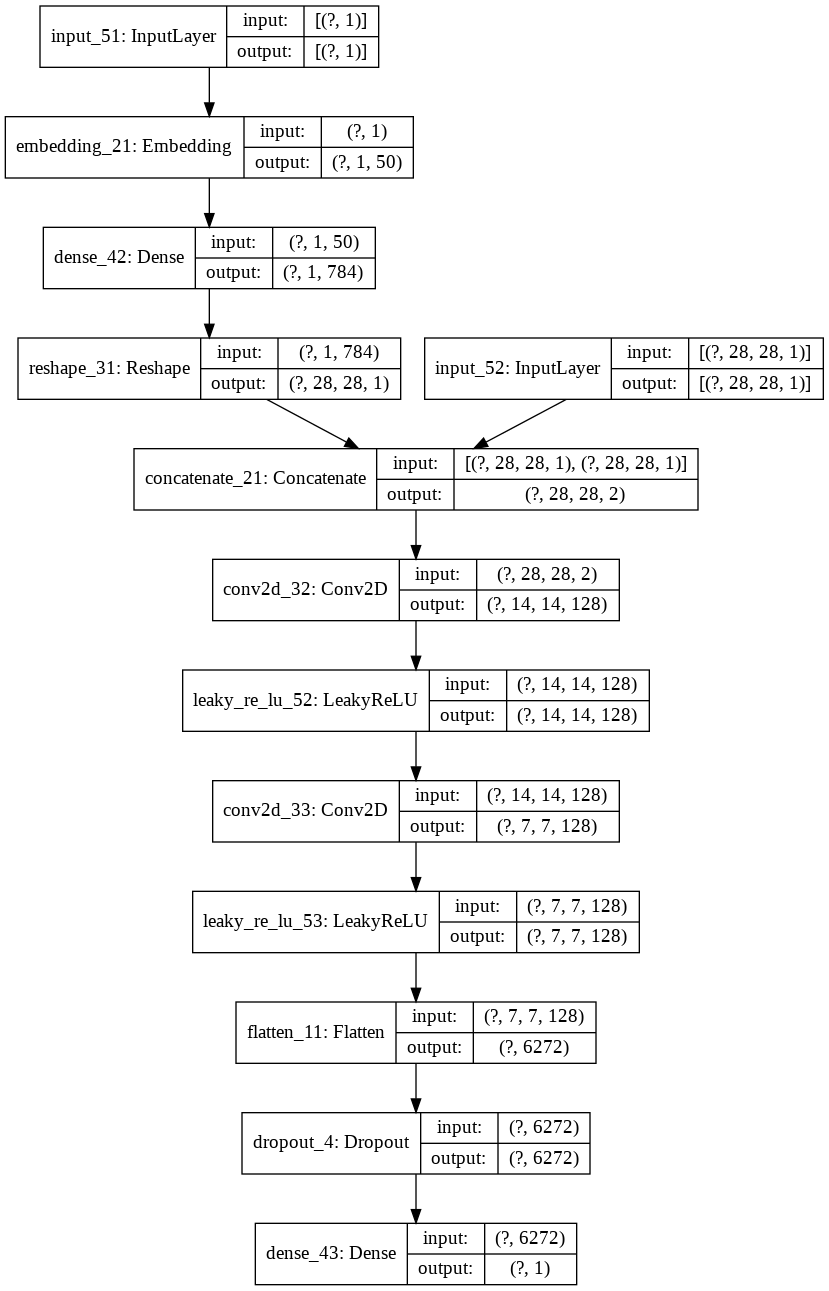

In [100]:
plot_model(model, show_layer_names=True, show_shapes=True)

# Define Generator

In [0]:
def define_generator(latent_dim, n_classes=10):
  # Embedding branch
  in_label = layers.Input(shape=(1,))
  li = layers.Embedding(n_classes, 50)(in_label)
  n_nodes = 7*7
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((7,7,1))(li)

  # Latent space branch
  in_lat = layers.Input(shape=(latent_dim,))
  n_nodes = 128 * 7 * 7
  gen = layers.Dense(n_nodes)(in_lat)
  gan = layers.LeakyReLU(alpha=0.2)(gen)
  gen = layers.Reshape((7,7,128))(gen)

  # Merge into common branch
  merge = layers.Concatenate()([gen, li])
  gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = layers.LeakyReLU(alpha=0.2)(gen)
  gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = layers.LeakyReLU(alpha=0.2)(gen)

  # Output layer
  out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

  model = models.Model([in_lat, in_label], out_layer)
  return model

In [102]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 50)        500         input_53[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 6272)         633472      input_54[0][0]                   
___________________________________________________________________________________________

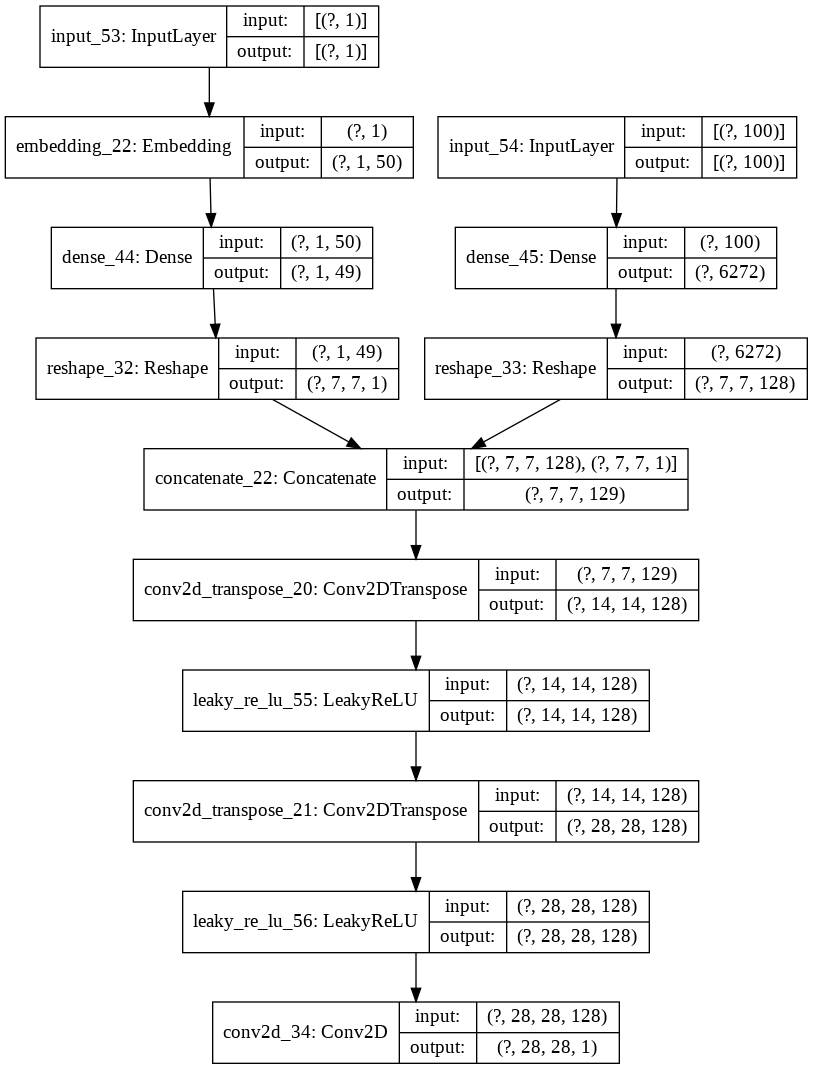

In [103]:
plot_model(model, show_layer_names=True, show_shapes=True)

# Define Composite GAN Model

In [0]:
def define_gan(g_model, d_model):
  # Freeze discriminator layers in composite model
  d_model.trainable = False
  # Input to the generator model will be input to composite gan model
  gen_noise, gen_label = g_model.input
  # Output of the generator model as input to discriminator model
  gen_output = g_model.output
  # Output of composite gan model will come from discriminator model
  gan_output = d_model([gen_output, gen_label])
  # Defining input and output of composite gan model
  model = models.Model([gen_noise, gen_label], gan_output)
  # Compile composite gan model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [0]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

In [106]:
gan_model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 50)        500         input_57[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 6272)         633472      input_58[0][0]                   
___________________________________________________________________________________________

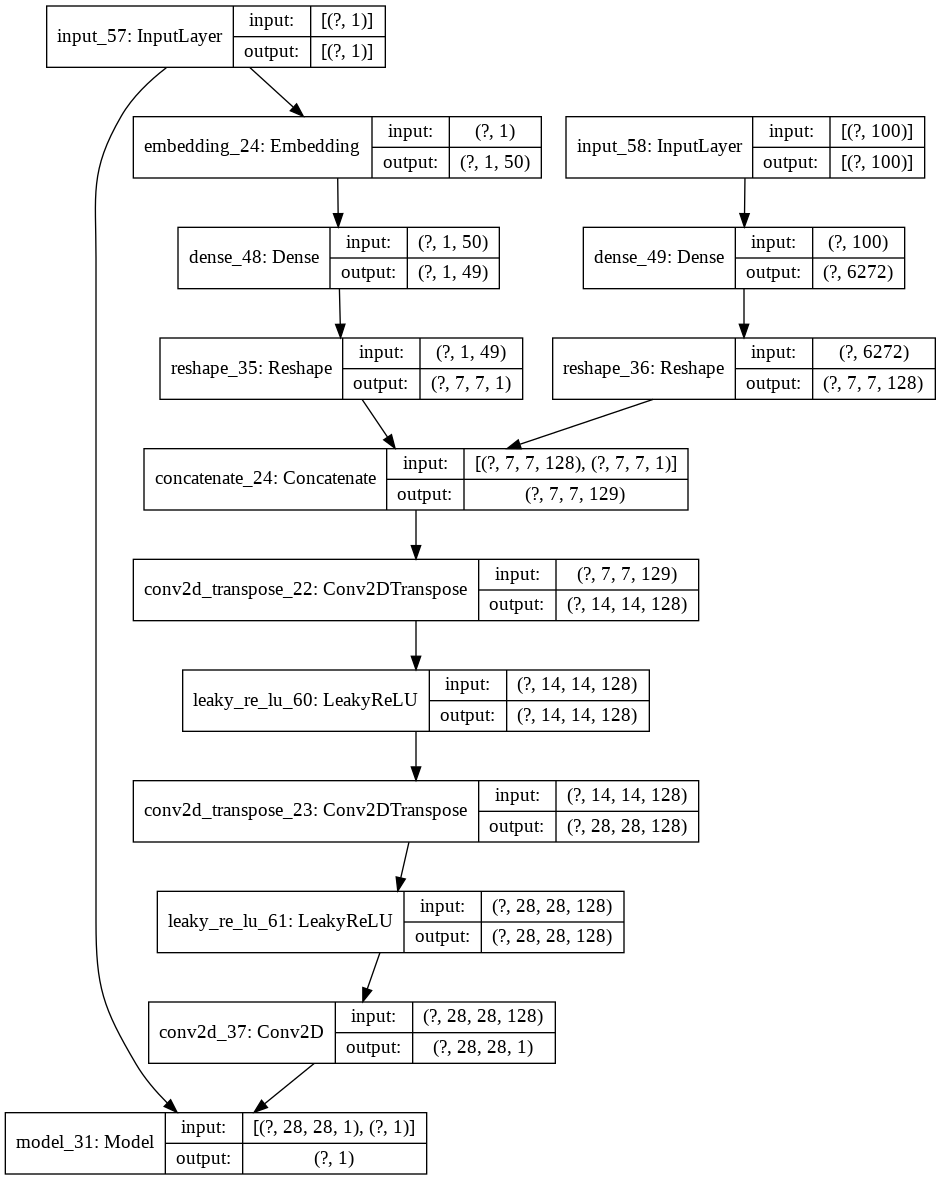

In [107]:
plot_model(gan_model, show_layer_names=True, show_shapes=True)

# Utitlity Functions

In [0]:
def load_real_samples():
  (trainX, trainy), (_, _) = load_data()
  X = np.expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  X = (X-127.5) / 127.5
  return [X, trainy]

In [0]:
def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = np.ones((n_samples, 1))
  return [X, labels], y

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = np.random.randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

In [0]:
def generate_fake_samples(generator, latent_dim, n_samples):
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  images = generator.predict([z_input, labels_input])
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

# Train GAN Model

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    g_model.save('cgan_generator_%d.h5' % (i+1))

In [0]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()

In [0]:
train(g_model, d_model, gan_model, dataset, latent_dim)

# Generate Samples of each class

In [0]:
def save_plot(examples, n):
  plt.figure(figsize=(10,10))
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')

In [118]:
model = models.load_model('cgan_generator_100.h5')

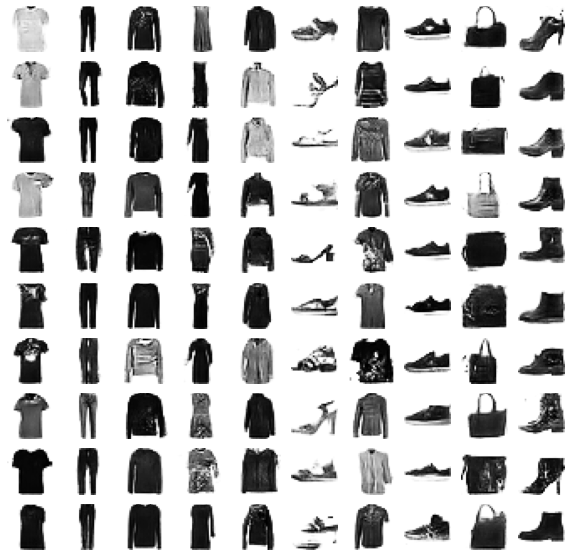

In [119]:
latent_points, labels = generate_latent_points(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 10)